In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

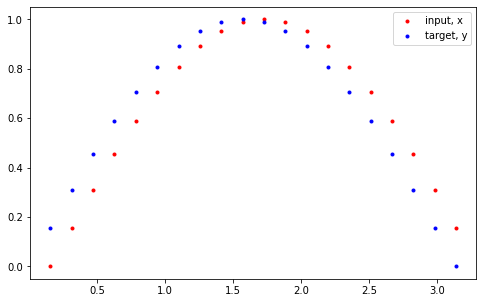

In [45]:

seq_length = 20

#dados

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)

#dimensao: (seq_length+1, 1)
data.resize((seq_length + 1, 1)) 

#input
x = data[:-1]
#target
y = data[1:]

#display
plt.figure(figsize=(8,5))
plt.plot(time_steps[1:], x, 'r.', label='input, x')
plt.plot(time_steps[1:], y, 'b.', label='target, y')

plt.legend(loc='best')
plt.show()

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        '''
        input_size - dimensao da entrada
        hidden_dim - numero de features
        n_layers - numero de camadas RNN (usualmente entre 1 e 3)
        '''
        super(RNN, self).__init__()
        self.hidden_dim=hidden_dim
        #RNN
        #batch_first - batch_size na primeira dimensão da entrada: (batch_size, seq_length, hidden_dim)
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        #fully-connected
        self.fc = nn.Linear(hidden_dim, output_size)

        
    def forward(self, x, hidden):
        '''
        x - (batch_size, seq_length, input_size)
        hidden - (n_layers, batch_size, hidden_dim)
        r_out - (batch_size, time_step, hidden_size)
        '''
        
        batch_size = x.size(0)
        
        #Saida RNN
        r_out, hidden = self.rnn(x, hidden)
        
        #reshape: (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        #prediction
        output = self.fc(r_out)
        
        return output, hidden

In [35]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=30, n_layers=1)

#dados
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((20, 1))

#converte data para Tensor. batch_size = 1 na primeira dimensão
test_input = torch.Tensor(data).unsqueeze(0) 
print('Input size: ', test_input.size())

#Saida da RNN
test_out, test_h = test_rnn(test_input,None )
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([1, 1, 30])


In [36]:
n_steps = 90
print_every = 100

In [58]:
def train(rnn, n_steps, print_every):
    
    # initializa o hidden state
    hidden = None      

    for batch_i, step in enumerate(range(n_steps)):
        #dados de treino
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        #input_size=1
        data.resize((seq_length + 1, 1)) 

        x = data[:-1]
        y = data[1:]

        # converte data para Tensor, batch_size = 1
        x_tensor = torch.Tensor(x).unsqueeze(0) 
        y_tensor = torch.Tensor(y)

        #saida do bloco RNN
        prediction, hidden = rnn(x_tensor, hidden)
        hidden = hidden.data

        # calcula loss
        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()

        #backpropagation e atualização dos pesos
        loss.backward()
        optimizer.step()

        #display
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.')
            plt.show()

    return rnn

In [59]:
#hiperparametros
input_size=1 
output_size=1
hidden_dim=5
n_layers=1

#RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)


In [60]:
# MSE loss, otimizador Adam e learning rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

Loss:  0.38133424520492554


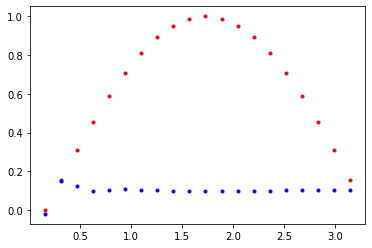

Loss:  0.05412216857075691


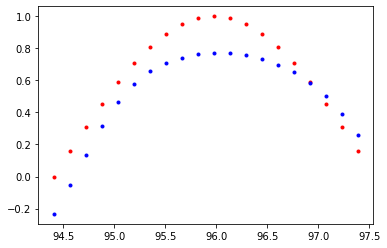

Loss:  0.02243489772081375


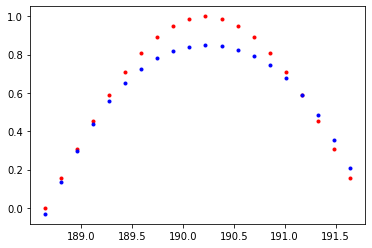

In [61]:
#treino
n_steps = 90
print_every = 30

trained_rnn = train(rnn, n_steps, print_every)

In [110]:
#predict
x = np.linspace(0,np.pi,20)
x.resize((len(x), 1)) 
x_tensor = torch.Tensor(x).unsqueeze(0) 

prediction, hidden = rnn(x_tensor, None)

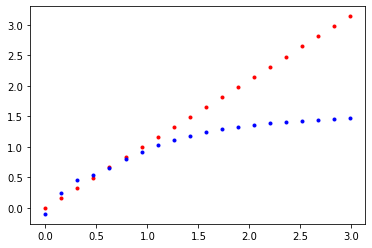

In [111]:
plt.plot(time_steps[:len(x)], x, 'r.')
plt.plot(time_steps[:len(x)], prediction.data.numpy().flatten(), 'b.')
plt.show()